In [11]:
### Run this cell before continuing.
library(cowplot)
library(datateachr)
library(digest)
library(infer)
library(repr)
library(taxyvr)
library(tidyverse)

*STAT 201 - GROUP 7*

# Comparing Vehicle Theft Rates in Vancouver, BC. 

Analysis by Soham Chakote, Lisa Desjarlais, Kiersten Lyde-Stad, Hongli Zhang

<font color='darkred'>
% Note For Team
    
I decided to just combine West End with CBD and Strathcona with Grandview-Woodland from the beginning. I just think it makes coding a lot more easier and idk why we would have it separate if we are comparing them together anyways. Hope that's good! - Lisa</font>

# Introduction

### Background

Police departments throughout the Lower Mainland and Vancouver Island are becoming increasingly concerned with the rising number of catalytic converter thefts in BC [(Marsten, 2023).](https://vancouver.citynews.ca/2023/01/11/catalytic-converter-theft-saanich/) In 2022, Surrey RCMP noted general thefts from vehicles were up an alarming twenty-two percent [(Moman, 2022).](https://www.surreynowleader.com/news/surrey-seeing-increase-in-catalytic-converter-thefts-police-offer-tips-to-protect-cars/) This rising level of crime in Vancouver has raised concerns over the safety of Vancouverites since weapons are being used to perpetrate these thefts [(VPD, 2021).]( https://vpd.ca/news/2021/10/20/vpd-project-leads-to-catalytic-converter-theft-arrests/) As a result police are warning residents to “be vigilant in where they park their vehicles” [(Marsten, 2023).](https://vancouver.citynews.ca/2023/01/11/catalytic-converter-theft-saanich/) Andresen and Malleson [(2011, as cited in Andresen et al., 2017),](https://doi.org/10.1007/s10940-016-9295-8) found fifty percent of crimes, such as assault, burglary, robbery, sexual assault, theft, and thefts of and from vehicles, over a ten year period were committed in less than nine percent of Vancouver’s streets. Most residents consider areas such as the Central Business District (CBD) and West End a lot safer than others, particularly like Strathcona and Grandview-Woodland. We plan to use statistical inference methods to determine if the proportion of thefts from vehicles does in fact vary significantly between these four districts of Vancouver: the Central business District and West End versus Strathcona and Grandview-Woodland. Because police and analysts are working together to count the number of crimes and find causes, we will use data gathered by the Vancouver Police Department made available for public use on their website. These data sets include statistics on which Vancouver district and date the thefts from vehicles occurred. The significance of collaborative monitoring has become a key element in later explanations of criminal behaviour [(Koop-Monteiro & Yasmin, 2021).](https://doi.org/10.3138/cjccj.2020-0013) 

### Question

### *"Concerning 2018 to 2022, is the proportion of thefts from vehicles in the Strathcona and Grandview-Woodland districts significantly lower than in the West End and Central Business districts of Vancouver, BC.?"*

# Methods & Results

##### Read, Clean, & Wrangle

In [12]:
#Set Seed
set.seed(2023)

# Read and Combine CSVS 
# Code from --
# Schork, J (2020). Import & Row-Bind CSV Files in R. https://statisticsglobe.com/merge-csv-files-in-r.
raw_crime <- list.files(path = "data/", 
                       pattern = "*.csv", full.names = TRUE) |>
    lapply(read_csv, show_col_types=FALSE) |>      #Quieted messages                      
    bind_rows() |>
    select(YEAR, NEIGHBOURHOOD, TYPE)
# merging select districts
crime_combined1 <- raw_crime |>
    filter(NEIGHBOURHOOD %in% c("Central Business District","West End")) |>
    mutate(NEIGHBOURHOOD = "West End & CBD")
crime_combined2 <- raw_crime |>
    filter(NEIGHBOURHOOD %in% c("Strathcona","Grandview-Woodland")) |>
    mutate(NEIGHBOURHOOD = "Strathcona & Grandview-Woodland")
# Combining data sets
crime <- rbind(crime_combined1, crime_combined2)
    
head(crime)

YEAR,NEIGHBOURHOOD,TYPE
<dbl>,<chr>,<chr>
2018,West End & CBD,Theft from Vehicle
2018,West End & CBD,Theft from Vehicle
2018,West End & CBD,Theft from Vehicle
2018,West End & CBD,Theft from Vehicle
2018,West End & CBD,Theft from Vehicle
2018,West End & CBD,Theft from Vehicle


Table 1. *Crime data set consisting of theft from vehicle statistics in the Central Business District/West End and Strathcona/Grandview-Woodland.*

##### Plot(s)

First we investigate the total thefts from vehicles over five years (2018-2022). Below we can see a spike in thefts in 2019, but a decrease in thefts from 2020 to 2021 and a slight increase in 2022, for our particular districts. This appears to be in opposition to the reported increase in thefts throughout the Lower Mainland and Vancouver Island. However we would need to investigate previous years to gain a better perspective.

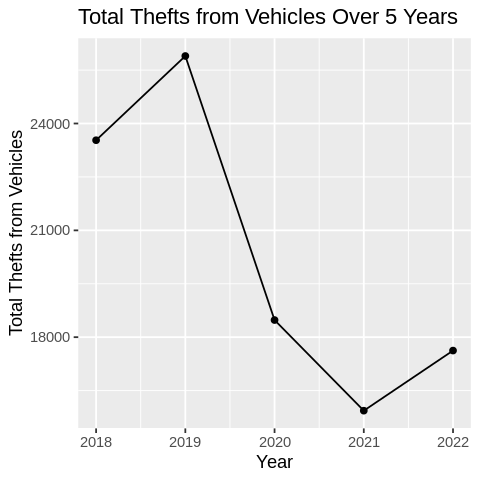

In [13]:
options(repr.plot.width = 4, repr.plot.height = 4)
# Crime Trend Over 5 Years
total_theft_trend <- crime |>
    group_by(YEAR) |>
    summarize(total_theft = n())

total_theft_trend_plot <- total_theft_trend |>
    ggplot(aes(x = YEAR, y = total_theft)) +
    geom_point() +
    geom_line() +
    labs(y = "Total Thefts from Vehicles", x = "Year", title = "Total Thefts from Vehicles Over 5 Years")

total_theft_trend_plot

Figure 1. *Theft from vehicle crime trend over 5 years in 4 districts: CBD, West End, Strathcona, Grandview-Woodland.*

Now, we investigate the proportions of thefts for the two regions and visualize our results.

In [14]:
# Determining Proportion of Crime in each district
n_all_thefts <- nrow(crime)

crime_theft_prop <- crime |>
    group_by(NEIGHBOURHOOD) |>
    summarize(n_thefts = n(),
              prop = n_thefts / n_all_thefts)
crime_theft_prop

NEIGHBOURHOOD,n_thefts,prop
<chr>,<int>,<dbl>
Strathcona & Grandview-Woodland,24159,0.2380948
West End & CBD,77309,0.7619052


Table 2. *Proportion of thefts in CBD/West End verus Strathcona/Grandview-Woodland.*

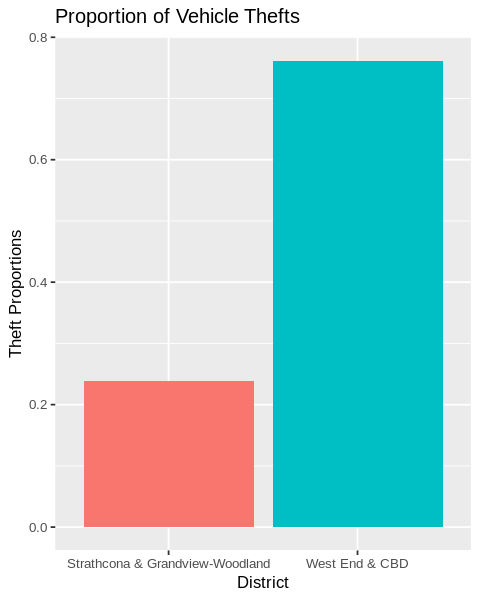

In [15]:
options(repr.plot.width = 4, repr.plot.height = 5)
prop_theft_plot <- crime_theft_prop |>
    ggplot(aes(x = NEIGHBOURHOOD, y = prop, fill = NEIGHBOURHOOD)) +
    geom_bar(stat = "identity") +
    labs(title = "Proportion of Vehicle Thefts", x = "District", y = "Theft Proportions") +
    theme(text = element_text(size = 10), legend.position = "vertical")
prop_theft_plot

Figure 2. Plot depicting theft proportions between CBD/West End and Strathcona/Grandview-Woodland (2018-2022).

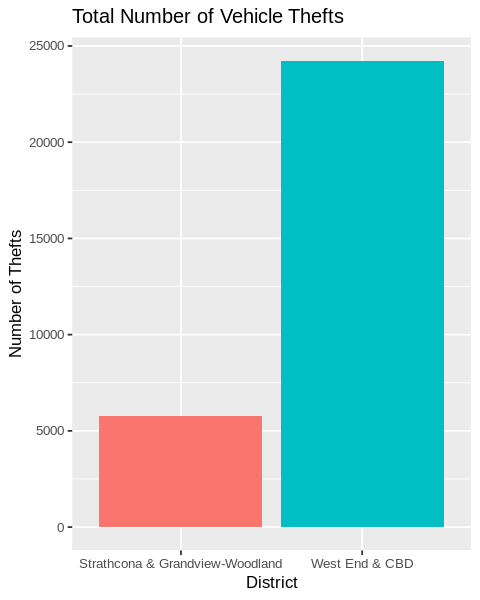

In [16]:
options(repr.plot.width = 4, repr.plot.height = 5)

all_thefts_plot <- crime |>
    filter(TYPE == "Theft from Vehicle") |>
    group_by(NEIGHBOURHOOD) |>
    summarize(n = n()) |>
    ggplot(aes(x = NEIGHBOURHOOD, y = n, fill = NEIGHBOURHOOD)) +
    geom_bar(stat = "identity") +
    labs(title = "Total Number of Vehicle Thefts", x = "District", y = "Number of Thefts") +
    theme(text = element_text(size = 10), legend.position = "vertical")
    
all_thefts_plot

Figure 3. *Plot depicting total number of vehicle thefts in CBD/West End and Strathcona/Grandview-Woodland (2018-2022).*

It appears that the majority of thefts from vehicles have taken place in the West End and Central Business District. This is not what we expected to find, given Strathcona and Grandview-Woodland's reputation. *(I'll probably add this explanation in the discussion section)* One possible explanation that may account for these results is population size. According to Hellosafe.ca [(Shepert, 2021),](https://www.vancouverisawesome.com/highlights/bc-ranks-3-in-canada-for-auto-thefts-3435784) the most populated Canadian regions generally have a higher number of auto thefts. 

...fill in...

In [17]:
crime_bootstrap <- crime |>
                   rep_sample_n(reps =1000, size =100, replace =TRUE) |>
                   group_by(replicate, NEIGHBOURHOOD)|>
                   summarise(prop = n()/100, .groups = "keep")
head(crime_bootstrap)
tail(crime_bootstrap)

replicate,NEIGHBOURHOOD,prop
<int>,<chr>,<dbl>
1,Strathcona & Grandview-Woodland,0.26
1,West End & CBD,0.74
2,Strathcona & Grandview-Woodland,0.21
2,West End & CBD,0.79
3,Strathcona & Grandview-Woodland,0.25
3,West End & CBD,0.75


replicate,NEIGHBOURHOOD,prop
<int>,<chr>,<dbl>
998,Strathcona & Grandview-Woodland,0.24
998,West End & CBD,0.76
999,Strathcona & Grandview-Woodland,0.21
999,West End & CBD,0.79
1000,Strathcona & Grandview-Woodland,0.26
1000,West End & CBD,0.74


Table 3. *Bootstrap estimates of proportions.*

...fill in..

In [18]:
point_estimates <- crime_bootstrap |>
                   group_by(NEIGHBOURHOOD) |>
                   summarise(mean_prop = mean(prop))
point_estimates

NEIGHBOURHOOD,mean_prop
<chr>,<dbl>
Strathcona & Grandview-Woodland,0.23912
West End & CBD,0.76088


Table 4. *Point estimates of Strathcona/Grandview-Woodland and West End/CBD proportions.*

In [19]:
# Calculate the observed difference in proportion
p_diff <- point_estimates$mean_prop[1] - point_estimates$mean_prop[2]
# Calculate the sample standard error of the difference in proportions
n1 <- nrow(crime_bootstrap %>% filter(NEIGHBOURHOOD == "Strathcona & Grandview-Woodland"))
n2 <- nrow(crime_bootstrap %>% filter(NEIGHBOURHOOD == "West End & CBD"))
p1 <- point_estimates$mean_prop[1]
p2 <- point_estimates$mean_prop[2]
p_diff_std_error <- sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)

# Combine results into a data frame
combined_df <- point_estimates |>
    mutate(p_diff = p_diff, p_diff_std_error = p_diff_std_error)

combined_df

NEIGHBOURHOOD,mean_prop,p_diff,p_diff_std_error
<chr>,<dbl>,<dbl>,<dbl>
Strathcona & Grandview-Woodland,0.23912,-0.52176,0.01907572
West End & CBD,0.76088,-0.52176,0.01907572


Table 5. The difference and standard error in proportion

In [20]:
combined_df <- 
    combined_df %>% 
    mutate(lower_ci = qnorm(0.025, p_diff, p_diff_std_error),
    upper_ci = qnorm(0.975, p_diff, p_diff_std_error)
)
combined_df

NEIGHBOURHOOD,mean_prop,p_diff,p_diff_std_error,lower_ci,upper_ci
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Strathcona & Grandview-Woodland,0.23912,-0.52176,0.01907572,-0.5591477,-0.4843723
West End & CBD,0.76088,-0.52176,0.01907572,-0.5591477,-0.4843723


Table 6. The 95% confidence interval for the difference in proportion

# Discussion

# References

Andresen, M. A., Linning, S. J., & Malleson, N. (2017). Crime at places and spatial concentrations: Exploring the spatial stability of property crime in Vancouver BC, 2003–2013. *Journal of Quantitative Criminology,* 33(2), 255-275. https://doi.org/10.1007/s10940-016-9295-8

Andresen, M. A., & Malleson, N. (2011). Testing the stability of crime patterns: Implications for theory and policy. *The Journal of Research in Crime and Delinquency,* 48(1), 58-82. https://doi.org/10.1177/0022427810384136

Koop-Monteiro, Yasmin. “The Social Organization of Community-Run Place: An Analysis of Community Gardens and Crime in Vancouver (2005–2015).” *Canadian Journal of Criminology and Criminal Justice,* 63, no. 1 (2021): 23–51. https://doi.org/10.3138/cjccj.2020-0013.

Marsten, E. (2023, January 11). *B.C. police agencies warn of catalytic converter thefts.* City News Everywhere. https://vancouver.citynews.ca/2023/01/11/catalytic-converter-theft-saanich/

Moman, S. (2022, August 26). Surrey seeing increase in catalytic converter thefts, police offer tips to protect cars. *Surrey Now-Leader.* https://www.surreynowleader.com/news/surrey-seeing-increase-in-catalytic-converter-thefts-police-offer-tips-to-protect-cars/

PRIME BC Police Records Management System (RMS). *Crime Data Download*. Accessed March 2023. https://geodash.vpd.ca/opendata/

Schork, J (2020). Import & Row-Bind CSV Files in R. https://statisticsglobe.com/merge-csv-files-in-r.

Shepert, E. (2021, Feburary 17). *B.C. ranks #3 in Canada for auto thefts.* Vancouver is Awesome. https://www.vancouverisawesome.com/highlights/bc-ranks-3-in-canada-for-auto-thefts-3435784 

Vancouver Police Department. (2021, October 20). VPD project leads to catalytic converter theft arrests [Press Release]. https://vpd.ca/news/2021/10/20/vpd-project-leads-to-catalytic-converter-theft-arrests/
